In [3]:
import pandas as pd
import torch
import pickle
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import concurrent.futures


df = pd.read_csv('reviews.csv').dropna(subset=['Review'])
df['Review'] = df['Review'].astype(str)


def map_scores_to_categories(score):
    # Calculate the category based on score range
    category = min(score // 10, 9)
    return category


df['Score'] = df['Score'].apply(map_scores_to_categories)

df

,ID,Game,Website,Review,Score
0,1,The Legend of Zelda: Ocarina of Time,Nintendorks,"The biggest, most heartpounding and awe-inspir...",9
1,2,The Legend of Zelda: Ocarina of Time,Weekly Famitsu,10 / 10 / 10 / 10 - platinum [first ever perfe...,9
2,3,The Legend of Zelda: Ocarina of Time,Gaming Maxx,"Nothing but pure 100% fun, challenging, and le...",9
3,4,The Legend of Zelda: Ocarina of Time,IGN,"Call us crazy, but when the final version of Z...",9
4,5,The Legend of Zelda: Ocarina of Time,Nintendojo,[Review Score = 110] What's significant about...,9
...,...,...,...,...,...
321243,322648,Family Party: 30 Great Games Obstacle Arcade,Nintendo Life,"As clunky and poorly considered as its title, ...",1
321244,322649,Family Party: 30 Great Games Obstacle Arcade,Game Revolution,"Family Party is terrible. Not only is it bad, ...",0
321245,322650,Disney Dreamlight Valley,God is a Geek,Disney Dreamlight Valley is brimming with Disn...,9
321246,322651,Disney Dreamlight Valley,Noisy Pixel,"If the change had happened much sooner, with e...",7


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Split the dat# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Review'], df['Score'], stratify=df['Score'], test_size=0.2
)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_length=256)

# Function to tokenize a batch of texts
def batch_tokenize(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors = 'pt')

# Function to process texts in parallel
def parallel_tokenize(texts, chunk_size=100):
    # Split texts into chunks
    chunks = [texts[i:i + chunk_size] for i in range(0, len(texts), chunk_size)]
    
    # Process each chunk in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(batch_tokenize, chunks))
    
    # Initialize combined results
    combined_results = {key: [] for key in results[0]}
    for result in results:
        for key in result:
            combined_results[key].extend(result[key])
    
    return combined_results


In [5]:
# Tokenize the texts in parallel
train_encodings = parallel_tokenize(list(train_texts))
val_encodings = parallel_tokenize(list(val_texts))


In [6]:
def save_data(data, file_path):
    with open(file_path, 'wb') as file:
        torch.save(data, file)

# Save train and validation data
save_data(train_encodings, 'train_meta_encodings_random.pkl')
save_data(val_encodings, 'val_meta_encodings_random.pkl')
save_data(train_labels.tolist(), 'train_meta_labels_random.pkl')
save_data(val_labels.tolist(), 'val_meta_labels_random.pkl')

In [7]:
import pandas as pd
import torch
import pickle
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import concurrent.futures

# Function to load encodings from disk
def load_encodings(file_path):
    with open(file_path, 'rb') as file:
        encodings = torch.load(file)
    return encodings

# Load train and validation encodings
train_encodings = load_encodings('train_meta_encodings_random.pkl')
val_encodings = load_encodings('val_meta_encodings_random.pkl')


# Function to load labels from disk
def load_labels(file_path):
    with open(file_path, 'rb') as file:
        labels = torch.load(file)
    return labels

# Load train and validation labels
train_labels = load_labels('train_meta_labels_random.pkl')
val_labels = load_labels('val_meta_labels_random.pkl')


In [8]:
# Define multi-label dataset class
class MultiLabelReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Use float for multi-labels
        return item

    def __len__(self):
        return len(self.labels)

# Convert encodings and labels into a PyTorch dataset
train_dataset = MultiLabelReviewDataset(train_encodings, train_labels)
val_dataset = MultiLabelReviewDataset(val_encodings, val_labels)


In [9]:
import shutil
import os


total, used, free = shutil.disk_usage("/")

print("Disk space statistics:")
print(f"Total: {total / (2**30):.2f} GB")
print(f"Used: {used / (2**30):.2f} GB")
print(f"Free: {free / (2**30):.2f} GB")

Disk space statistics:
Total: 1863.00 GB
Used: 472.18 GB
Free: 1390.82 GB


Loading model from last checkpoint: ./results_meta\checkpoint-160620


C:\Users\peebl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/160620 [00:00<?, ?it/s]

{'train_runtime': 0.5431, 'train_samples_per_second': 4731553.922, 'train_steps_per_second': 295735.929, 'train_loss': 0.0, 'epoch': 10.0}


C:\Users\peebl\AppData\Local\Temp\ipykernel_9028\460231580.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/251 [00:00<?, ?it/s]

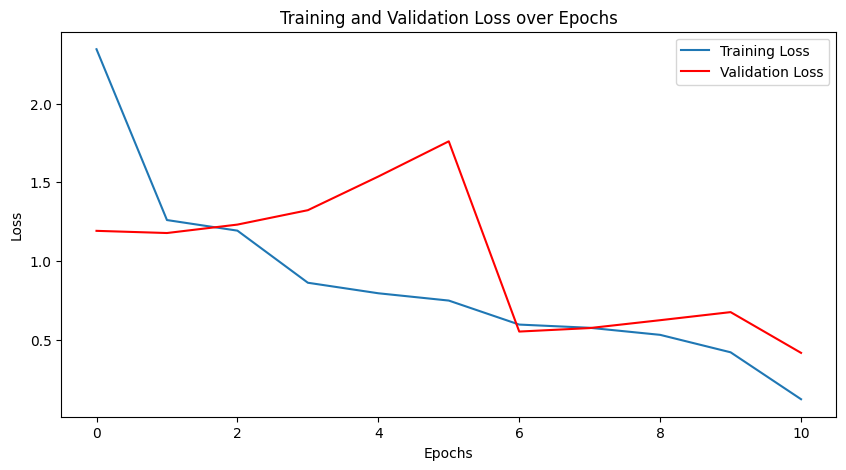

{'eval_loss': 0.4156457483768463, 'eval_runtime': 203.5238, 'eval_samples_per_second': 315.668, 'eval_steps_per_second': 1.233, 'epoch': 10.0}


In [21]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
import os
from transformers import BertTokenizer
from matplotlib import pyplot as plt

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_length=256)

num_labels = len(set(train_labels))
max_length = 128
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

df = pd.read_csv('reviews.csv').dropna(subset=['Review'])

def find_last_checkpoint(output_dir):
    """
    Finds the last checkpoint directory in the specified output directory.
    Assumes checkpoint directories follow the format 'checkpoint-xxxx'.
    """
    checkpoints = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("checkpoint")]
    if not checkpoints:
        return None
    return max(checkpoints, key=os.path.getmtime)

last_checkpoint = find_last_checkpoint('./results_meta')

if last_checkpoint:
    print(f"Loading model from last checkpoint: {last_checkpoint}")
    model = BertForSequenceClassification.from_pretrained(last_checkpoint, num_labels=num_labels)
    model = model.to(device)
    x = True
else:
    print("No checkpoints found, initializing from base model.")
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
    model = model.to(device)
    x = False

# Training arguments
training_args = TrainingArguments(
    output_dir='./results_meta',     # Output directory to save checkpoints
    num_train_epochs=10,             # Increased number of training epochs
    per_device_train_batch_size=128,  # Batch size for training
    per_device_eval_batch_size=256,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs_meta',
    logging_strategy= "epoch",       # Directory for storing logs
    logging_steps=10,                # How often to log loss values
    evaluation_strategy="epoch",     # Evaluate each epoch
    save_strategy="epoch",           # Save the model every epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
)

# Iinitialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)


trainer.train(resume_from_checkpoint=x)



evaluation_results = trainer.evaluate()


train_loss= []
seen = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        if elem['epoch'].is_integer() and elem["epoch"] not in seen:
            train_loss.append(elem['loss'])
            seen.append(elem["epoch"])

val_loss = []
for elem in trainer.state.log_history:
    if 'eval_loss' in elem.keys():
        val_loss.append(elem['eval_loss'])


plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, color = "red", label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(evaluation_results)

In [22]:
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# Load the trained model and tokenizer into a pipeline
# Make sure to adjust the model path if you've saved your model elsewhere
model_path = './results_meta\checkpoint-48186'  # This path should point to the directory containing your saved model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',max_length = 256)

# Create a text classification pipeline
classifier = pipeline("text-classification", model=model_path, tokenizer=tokenizer)


# Example text to classify
texts = ["One of the best games I've every player perfect in every way, really makes you feel like Grimbly is in your room collecting creamed corn right with you"]

# Make predictions
predictions = classifier(texts)

# Process and print predictions
for text, prediction in zip(texts, predictions):
    print(f"Text: {text}\nPredicted label: {prediction['label']} with score: {prediction['score']:.4f}\n")

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\peebl\AppData\Local\Temp\ipykernel_9028\3514188478.py:5: SyntaxWarning: invalid escape sequence '\c'
  model_path = './results_meta\checkpoint-48186'  # This path should point to the directory containing your saved model


Text: One of the best games I've every player perfect in every way, really makes you feel like Grimbly is in your room collecting creamed corn right with you
Predicted label: LABEL_9 with score: 0.9851

